## Imports

In [0]:
import pandas as pd
from sklearn import tree, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Cleaning

In [0]:
firesDF = pd.read_csv("/content/gdrive/My Drive/Big Data Analytics/Data/fires_processed.csv", low_memory=False)

In [0]:
firesML = firesDF[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE', 'DATE', 'MONTH', 'DAY_OF_WEEK']]

In [13]:
# Using state, cause, and day of week for label encoding
le = preprocessing.LabelEncoder()
firesML['STAT_CAUSE_DESCR'] = le.fit_transform(firesML['STAT_CAUSE_DESCR'])
firesML['STATE'] = le.fit_transform(firesML['STATE'])
firesML['DAY_OF_WEEK'] = le.fit_transform(firesML['DAY_OF_WEEK'])
firesML.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,2453403.5,0.10,2005-02-02,2,6
1,2004,6,38.933056,-120.404444,4,2453137.5,0.25,2004-05-12,5,6
2,2004,3,38.984167,-120.735556,4,2453156.5,0.10,2004-05-31,5,1
3,2004,6,38.559167,-119.913333,4,2453184.5,0.10,2004-06-28,6,1
4,2004,6,38.559167,-119.933056,4,2453184.5,0.10,2004-06-28,6,1


In [14]:
#Dropping all the NA's in the dataset and Irrelevant Columns
firesML = firesML.dropna()
firesML = firesML.drop('DATE',axis=1)
print(firesML.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE  ...  FIRE_SIZE  MONTH  DAY_OF_WEEK
0       2005                 7  40.036944  ...       0.10      2            6
1       2004                 6  38.933056  ...       0.25      5            6
2       2004                 3  38.984167  ...       0.10      5            1
3       2004                 6  38.559167  ...       0.10      6            1
4       2004                 6  38.559167  ...       0.10      6            1

[5 rows x 9 columns]


# Machine Learning

## Overall Random Forest Classifier

In [0]:
# Our goal is to predict the causes of fire i,e;  STAT_CAUSE_DESCR 
# creating training and test dataset as we will be using supervised learning in our project
X = firesML.drop(["STAT_CAUSE_DESCR"], axis=1).values
Y = firesML['STAT_CAUSE_DESCR'].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 0) # 25% for testing and 75% for training


There are a lot of different classes, we want to put some of these together and have just 4 classes for the cause of fires. Then test again to see if the score improves. The 4 classes are: natural, accidental, malicious and other where natural = ['Lightning'] accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning'] malicious = ['Arson'] other = ['Missing/Undefined','Miscellaneous']

In [0]:
firesDF_orig = firesDF.copy()
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        return 0
    elif cat in accidental:
        return 1
    elif cat in malicious:
        return 2
    else:
        return 3

causes = {}
plausible = ['Natural', 'Accidental', 'Malicious', 'Other']
count = 0
for cause in plausible:
  causes[count] = cause
  count += 1

firesML['LABEL'] = firesDF_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
firesML = firesML.drop('STAT_CAUSE_DESCR',axis=1)

**We've now replaced STAT_CAUSE_DESCR with LABEL. So now I will now try to predict LABEL**

In [17]:
from keras.utils import *
X = firesML.drop(['LABEL', 'FIRE_YEAR', 'STATE'], axis=1).values
y = firesML['LABEL'].values
y_hat = to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X,y_hat,test_size=0.25, random_state=0)

Using TensorFlow backend.


### Training and Finding Accuracy

In [18]:
clf_rf = RandomForestClassifier(n_estimators=15)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.6148958663481644


### Analysis

In [19]:
firesML.drop(['LABEL', 'FIRE_YEAR', 'STATE'], axis=1)

,LATITUDE,LONGITUDE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,40.036944,-121.005833,2453403.5,0.10,2,6
1,38.933056,-120.404444,2453137.5,0.25,5,6
2,38.984167,-120.735556,2453156.5,0.10,5,1
3,38.559167,-119.913333,2453184.5,0.10,6,1
4,38.559167,-119.933056,2453184.5,0.10,6,1
...,...,...,...,...,...,...
1880460,40.481637,-122.389375,2457291.5,0.01,9,2
1880461,37.617619,-120.938570,2457300.5,0.20,10,1
1880462,37.617619,-120.938570,2457144.5,0.10,5,2
1880463,37.672235,-120.898356,2457309.5,2.00,10,6


In [0]:
disco = firesML['DISCOVERY_DATE'].values
fire_size = firesML['FIRE_SIZE'].values

In [21]:
Latitude = float(input('Input Latititude: '))
Longitude = float(input('Input Longitude: '))
Month = float(input('Input Month: '))
Day_Of_Week = float(input('Input Day of Week: '))
# TODO If user wishes to input the following things, take those, else randomize
Discovery_Date = np.random.normal(disco.mean(), disco.std())
Fire_Size = np.random.normal(fire_size.mean(), fire_size.std())

Input Latititude: 30
Input Longitude: -80
Input Month: 10
Input Day of Week: 7


Natural : 0.0
Accidental : 0.4
Malicious : 0.13333333333333333
Other : 0.4666666666666667


<BarContainer object of 4 artists>

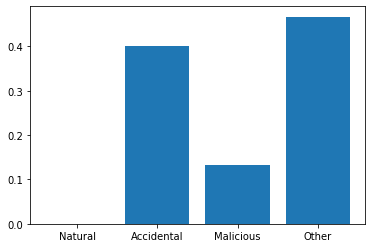

In [24]:
probs = []
test = np.array([Latitude, Longitude, Discovery_Date, Fire_Size, Month, Day_Of_Week])
temp = clf_rf.predict_proba(test.reshape((1, X_test[0].shape[0])))
for i in range(len(temp)):
  probs.append(temp[i][0][1])
  print(causes[i],':', temp[i][0][1])
import matplotlib.pyplot as plt
plt.bar(causes.values(), probs)

              precision    recall  f1-score   support

           0       0.45      0.88      0.59     69464
           1       0.70      0.70      0.70    207981
           2       0.65      0.38      0.48     69880
           3       0.76      0.54      0.63    122792

    accuracy                           0.63    470117
   macro avg       0.64      0.62      0.60    470117
weighted avg       0.67      0.63      0.63    470117



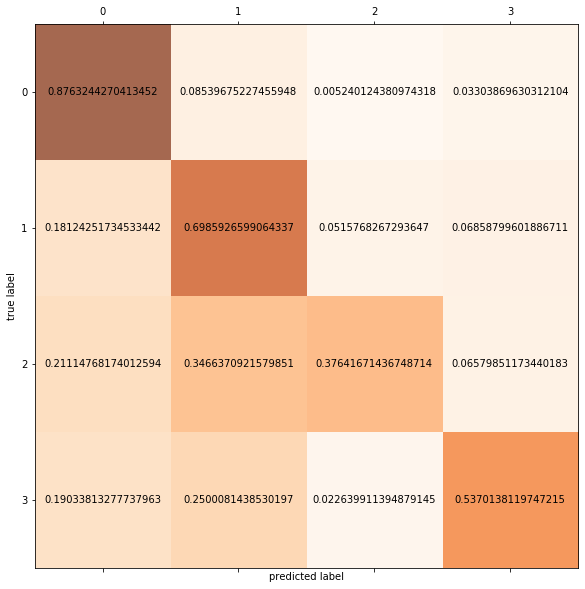

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_true=y_test.argmax(axis=1),y_pred=y_pred.argmax(axis=1))
cr = classification_report(y_true=y_test.argmax(axis=1),y_pred=y_pred.argmax(axis=1))
print(cr)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

**The random forest algorithm did well with the first two labels: natural and accidental (80% +) but did not do as well with the 'other' label and did quite badly with the 'malicious' label, it mistakingly labelled many of these as accidental**

**Summary: The original question was: Can we predict the cause of these wildfires using the data provided? The answer is yes, at least to an accuracy of 58% or better. Reducing the number of labels significantly improves the prediction score to 70% for the random forest algorithm. The algorithm did not perform well when trying to distingusih 'accidental' and 'malicious' causes. But with further tuning or a different algorithm it may be possible to fix this.**

In [0]:
# Save Model for exporting using joblib
# Note: Will be exported and used in Flask app
filename = 'wildfire_model.sav'
#joblib.dump(clf_rf, filename)

## Statewise

Given that it is easier to make accurate predictions if the number of classes is reduced,We want to look at three states (CA, NY & TX) and build a system that can predict if a fire was started maliciously given just some easy to obtain data: year, month, day of week, latitude and longitude of fire. We have dropped the FIRE_SIZE field because we want a system that could be used in the early stages of a fire to predict if the fire is the result of Arson. My goal is to use this data to get at least 90% accuracy

**Analysis for the state of California (CA)**

In [27]:
firesML1 = firesDF[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE', 'DATE', 'MONTH', 'DAY_OF_WEEK']]
df_NY = firesML1[firesDF['STATE']=='NY']
df_CA = firesML1[firesDF['STATE']=='CA']
df_TX = firesML1[firesDF['STATE']=='TX']


print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE  ...        DATE MONTH  DAY_OF_WEEK
0       2005    Miscellaneous  40.036944  ...  2005-02-02     2    Wednesday
1       2004        Lightning  38.933056  ...  2004-05-12     5    Wednesday
2       2004   Debris Burning  38.984167  ...  2004-05-31     5       Monday
3       2004        Lightning  38.559167  ...  2004-06-28     6       Monday
4       2004        Lightning  38.559167  ...  2004-06-28     6       Monday

[5 rows x 10 columns]


**Create a new field: ARSON**

In [28]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df_CA['ARSON'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
df_CA = df_CA.drop('DATE',axis=1)
df_CA = df_CA.drop('STATE',axis=1)
df_CA = df_CA.drop('STAT_CAUSE_DESCR',axis=1)
df_CA = df_CA.drop('FIRE_SIZE',axis=1)
df_CA = df_CA.dropna()

le = preprocessing.LabelEncoder()
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])


print(df_CA.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  MONTH  DAY_OF_WEEK  ARSON
0       2005  40.036944 -121.005833       2453403.5      2            6      0
1       2004  38.933056 -120.404444       2453137.5      5            6      0
2       2004  38.984167 -120.735556       2453156.5      5            1      0
3       2004  38.559167 -119.913333       2453184.5      6            1      0
4       2004  38.559167 -119.933056       2453184.5      6            1      0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**We can now test the ML:**

In [29]:
X1 = df_CA.drop(['ARSON'], axis=1).values
y1 = df_CA['ARSON'].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf1 = RandomForestClassifier(n_estimators=10)
clf_rf1 = clf_rf1.fit(X_train1, y_train1)
print(clf_rf1.score(X_test1,y_test1))

0.9168205398751429


**Now we do a similar analysis for the state of New York (NY)**

In [30]:
print(df_NY.head())

        FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE  ...        DATE MONTH  DAY_OF_WEEK
84588        1995          Smoking  42.533333  ...  1995-08-20     8       Sunday
84589        1995          Smoking  42.533333  ...  1995-08-20     8       Sunday
84590        1995            Arson  42.441111  ...  1995-09-05     9      Tuesday
109802       1998    Miscellaneous  42.588333  ...  1998-04-13     4       Monday
109803       1998        Lightning  42.561111  ...  1998-05-26     5      Tuesday

[5 rows x 10 columns]


**Field: Arson**

In [31]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df_NY['ARSON'] = df_NY['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
df_NY = df_NY.drop('DATE',axis=1)
df_NY = df_NY.drop('STATE',axis=1)
df_NY = df_NY.drop('STAT_CAUSE_DESCR',axis=1)
df_NY = df_NY.drop('FIRE_SIZE',axis=1)
df_NY = df_NY.dropna()

le = preprocessing.LabelEncoder()
df_NY['DAY_OF_WEEK'] = le.fit_transform(df_NY['DAY_OF_WEEK'])


print(df_NY.head())

        FIRE_YEAR   LATITUDE  LONGITUDE  ...  MONTH  DAY_OF_WEEK  ARSON
84588        1995  42.533333 -76.733333  ...      8            3      0
84589        1995  42.533333 -76.806944  ...      8            3      0
84590        1995  42.441111 -76.811389  ...      9            5      1
109802       1998  42.588333 -76.821667  ...      4            1      0
109803       1998  42.561111 -76.782500  ...      5            5      0

[5 rows x 7 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Now we test the ML**

In [32]:
X2 = df_NY.drop(['ARSON'], axis=1).values
y2 = df_NY['ARSON'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf2 = RandomForestClassifier(n_estimators=10)
clf_rf2 = clf_rf2.fit(X_train2, y_train2)
print(clf_rf2.score(X_test2,y_test2))

0.8770454639132764


**Analysis for the state of Texas (TX)**

In [33]:
print(df_TX.head())

     FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE  ...        DATE MONTH  DAY_OF_WEEK
283       2005            Arson  33.786111  ...  2005-01-24     1       Monday
284       2005   Debris Burning  31.312500  ...  2005-01-25     1      Tuesday
285       2005         Campfire  33.345833  ...  2005-03-12     3     Saturday
286       2005          Smoking  31.386667  ...  2005-04-03     4       Sunday
287       2005        Lightning  31.354167  ...  2005-04-07     4     Thursday

[5 rows x 10 columns]


In [34]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df_TX['ARSON'] = df_TX['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
df_TX = df_TX.drop('DATE',axis=1)
df_TX = df_TX.drop('STATE',axis=1)
df_TX = df_TX.drop('STAT_CAUSE_DESCR',axis=1)
df_TX = df_TX.drop('FIRE_SIZE',axis=1)
df_TX = df_TX.dropna()

le = preprocessing.LabelEncoder()
df_TX['DAY_OF_WEEK'] = le.fit_transform(df_TX['DAY_OF_WEEK'])


print(df_TX.head())

     FIRE_YEAR   LATITUDE  LONGITUDE  DISCOVERY_DATE  MONTH  DAY_OF_WEEK  ARSON
283       2005  33.786111 -96.150000       2453394.5      1            1      1
284       2005  31.312500 -94.270833       2453395.5      1            5      0
285       2005  33.345833 -97.595833       2453441.5      3            2      0
286       2005  31.386667 -95.150556       2453463.5      4            3      0
287       2005  31.354167 -95.085278       2453467.5      4            4      0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Now we test the ML**

In [35]:
X3 = df_TX.drop(['ARSON'], axis=1).values
y3 = df_TX['ARSON'].values
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf3 = RandomForestClassifier(n_estimators=10)
clf_rf3 = clf_rf3.fit(X_train3, y_train3)
print(clf_rf3.score(X_test3,y_test3))

0.941300725232943
